## Exercise: Wrangling Data: Acquisition, Integration, and Exploration

For this lab’s exercise we are going to answer a few questions about AirBnB listings in San Francisco to make a better informed civic descisions. Spurred by Prop F in San Francisco, imagine you are the mayor of SF (or your respective city) and you need to decide what impact AirBnB has had on your own housing situation. We will collect the relevant data, parse and store this data in a structured form, and use statistics and visualization to both better understand our own city and potentially communicate these findings to the public at large.

> I will explore SF's data, but the techniques should be generally applicable to any city. Inside AirBnB has many interesting cities to further explore: http://insideairbnb.com/

## Outline

* Start with Effective Questions
    * Intro + Data Science Overview
    * Proposition F
    * How can we answer this?
* Acquiring Data
    * What's an API? (Zillow API, SF Open Data, datausa.io)
    * How the Web Works (Socrata API)
* What if there is no API?
    * Scrape an AirBnB listing
* What to do now that we have data?
    * Basics of HTML (CSS selectors and grabbing what you want)
    * Use `lxml` to parse web pages
* Storing Data
    * Schemas and Structure
    * Relations (users, listings, and reviews)
    * Store listing in SQLite
* Manipulating Data
    * basics of Pandas
    * summary stats
    * split-apply-combine
    * Aggregations
    * Prop F. revenue lost
* Exploratory Data Analysis
    * Inside AirBnB
    * Why visual?
    * Chart Types (visualizing continuous, categorical, and distributions and facets)
    * Distributions of Prop F. Revenue vs. point statistics

# Visualize

### Time to visualize! Using pandas (and matplotlib) create a visualization of each of the following:
* Distribution of room_type (for entire city)
* Histogram of # of listings per neighborhood
* Histogram of # of listings for each user
* City wide distribution of listing price
* Distribution of median listing price per neighborhood
* Histogram of number of reviews per listing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# We will use the Inside AirBnB dataset from here on
df = pd.read_csv('data/sf_listings.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1162609,Lovely One Bedroom Apartment,6368122,Taylor,NaN,Seacliff,37.785217,-122.488655,Entire home/apt,350,4,8,2015-09-17,0.28,1,90
1,6032828,Historic Seacliff Home,30384615,Patricia,NaN,Seacliff,37.783658,-122.489398,Entire home/apt,300,1,0,NaN,NaN,1,173
2,6938818,Best Secret in Town,36381578,Harris,NaN,Seacliff,37.781505,-122.504754,Private room,119,1,10,2015-10-08,2.33,1,341
3,8087607,Single Room Beautiful Beach Condo,3264449,Keith,NaN,Seacliff,37.775318,-122.511621,Private room,79,1,0,NaN,NaN,1,40
4,4781448,3 Bd 2.5 Ba Full Flat Condo w Views,13112558,Pam,NaN,Seacliff,37.781797,-122.492492,Entire home/apt,695,2,1,2015-08-11,0.36,1,23


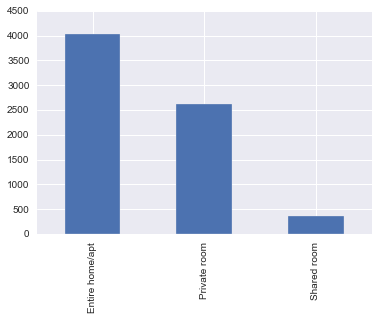

In [3]:
df.room_type.value_counts().plot.bar()

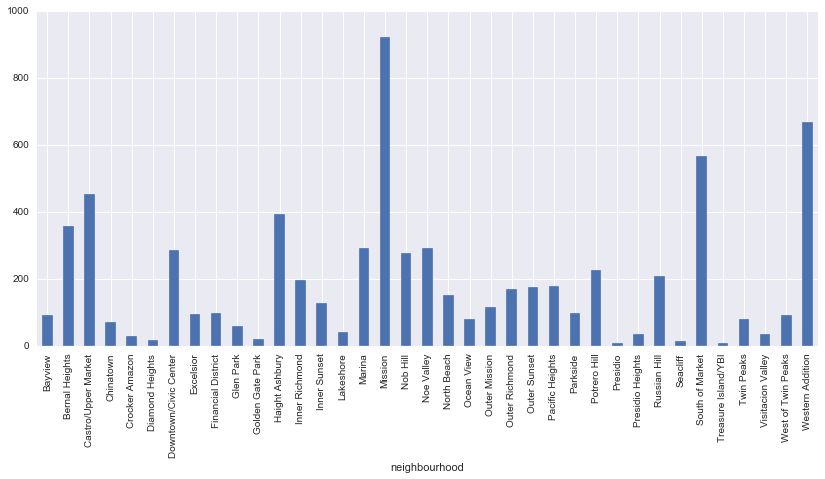

In [4]:
# Since SF doesn't have many neighborhoods (comparatively) we can also see the raw # per neighborhood
df.groupby('neighbourhood').count()['id'].plot.bar(figsize=(14,6))

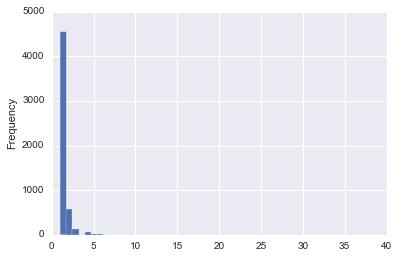

In [5]:
df.groupby('host_id').count()['id'].plot.hist(bins=50)

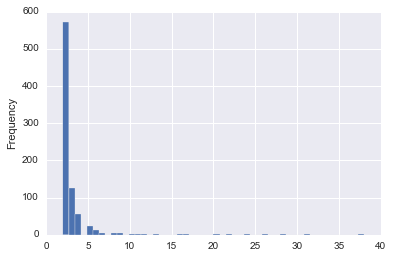

In [6]:
# let's zoom in to the tail
subselect = df.groupby('host_id').count()['id']
subselect[subselect > 1].plot.hist(bins=50)

In [7]:
def scale_free_plot(df, num):
    subselect = df.groupby('host_id').count()['id']
    return subselect[subselect > num].plot.hist(bins=75)

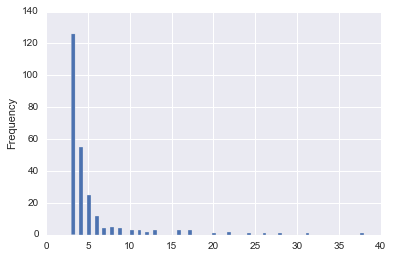

In [8]:
scale_free_plot(df, 2)

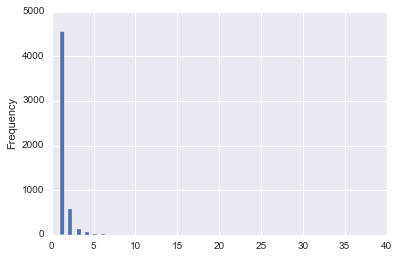

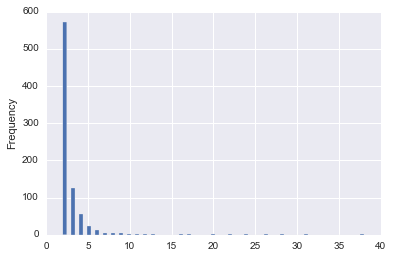

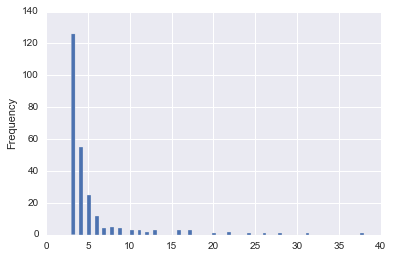

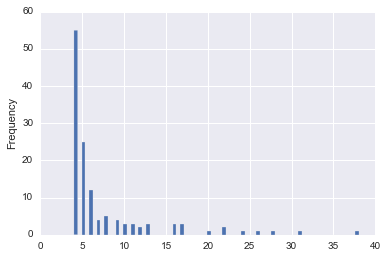

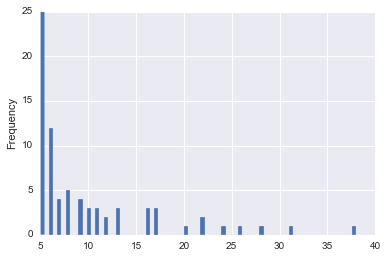

In [9]:
# the shape of the distribution stays relatively the same as we subselect
for i in range(5):
    scale_free_plot(df, i)
    plt.show()

### Scatterplot Matrix

In an effort to find potential correlations (or outliers) you want a little bit more fine grained loot at the data. Create a scatterplot matrix of the data for your city. http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-scatter-matrix

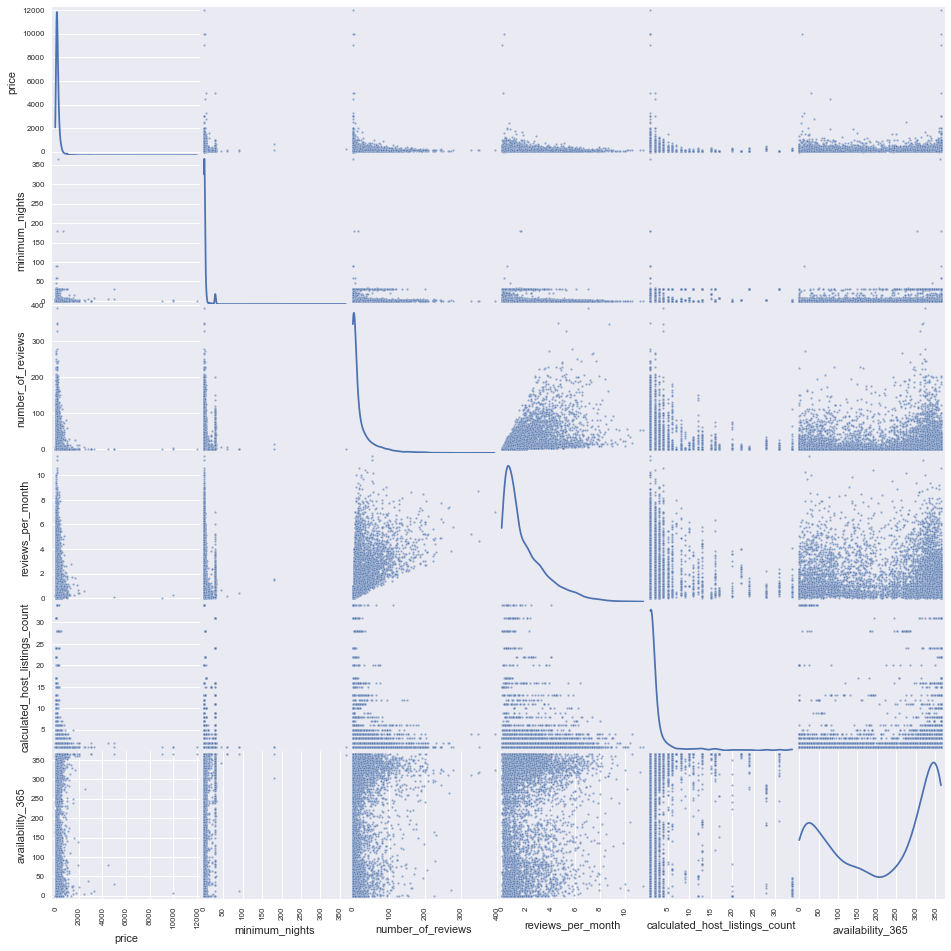

In [10]:
from pandas.tools.plotting import scatter_matrix

# it only makes sense to plot the continuous columns
continuous_columns = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', \
           'calculated_host_listings_count','availability_365']

# semicolon prevents the axis objests from printing
scatter_matrix(df[continuous_columns], alpha=0.6, figsize=(16, 16), diagonal='kde');

#### Interesting insights from the scatter matrix:

* `price` heavily skewed towards cheap prices (with a few extreme outliers). `host_listings_count` and `number_of_reviews` have similar distributions.
* `minimum_nights` has a sharp bimodal distribution.
* Listing are bimodal too and are either:
    * available for a relatively short period of the year
    * available for most of it (these are probably the ___"hotels"___)
* Host with a large number of listings have them each for a relative low price.
* Listings that are expensive have very few reviews (i.e. not many people stay at them)

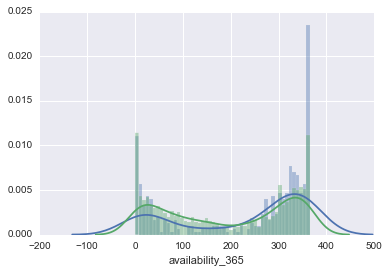

In [11]:
sns.distplot(df[(df.calculated_host_listings_count > 2) & (df.room_type == 'Entire home/apt')].availability_365, bins=50)
sns.distplot(df[(df.calculated_host_listings_count <= 2) & (df.room_type == 'Entire home/apt')].availability_365, bins=50)

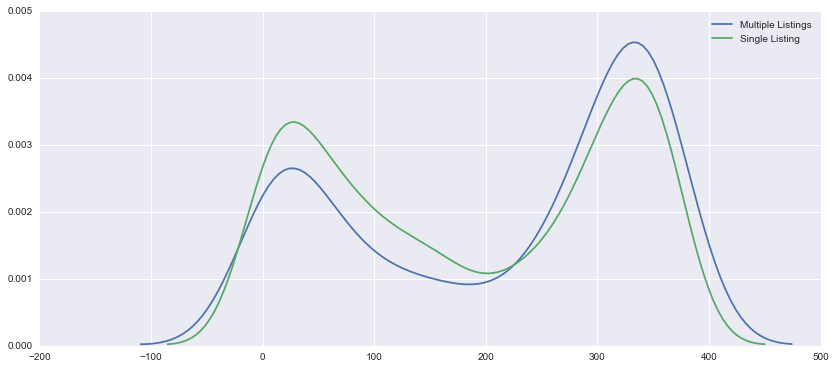

In [12]:
# Host with multiple listing for the entire home distribution is skewed to availability the entire year
# implying that these hosts are renting the AirBnB as short term sublets (or hotels)

entire_home = df[df.room_type == 'Entire home/apt']

plt.figure(figsize=(14,6))
sns.kdeplot(entire_home[entire_home.calculated_host_listings_count > 1].availability_365, label='Multiple Listings')
sns.kdeplot(entire_home[entire_home.calculated_host_listings_count == 1].availability_365, label = 'Single Listing')
plt.legend();

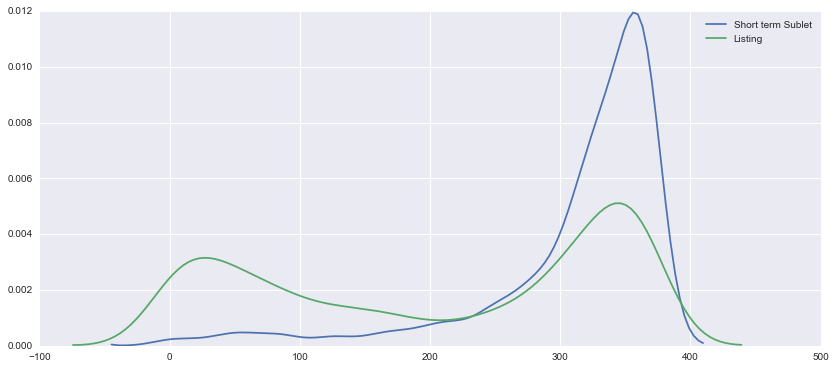

In [13]:
# Host with multiple listing for the entire home distribution is skewed to availability the entire year
# implying that these hosts are renting the AirBnB as short term sublets (or hotels)

plt.figure(figsize=(14,6))
sns.kdeplot(df[df.minimum_nights > 29].availability_365, label='Short term Sublet')
sns.kdeplot(df[df.minimum_nights <= 20].availability_365, label = 'Listing')
plt.legend();

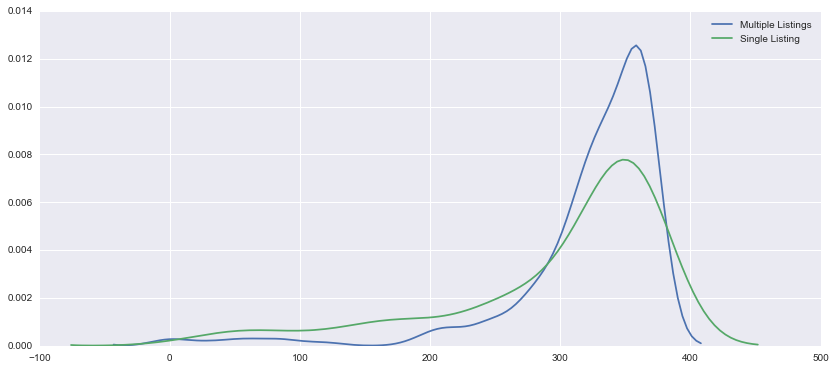

In [14]:
# Host with multiple listing for the entire home distribution is skewed to availability the entire year
# implying that these hosts are renting the AirBnB as short term sublets (or hotels)

entire_home = df[df.minimum_nights > 29]

plt.figure(figsize=(14,6))
sns.kdeplot(entire_home[entire_home.calculated_host_listings_count > 1].availability_365, label='Multiple Listings')
sns.kdeplot(entire_home[entire_home.calculated_host_listings_count == 1].availability_365, label = 'Single Listing')
plt.legend();

# Extra!

## Advanced Plots with Seaborn

### Make a violin plot of the price distribution of each neighborhood.
> If your city has a large number of neighborhoods plot the 10 with the most listing.


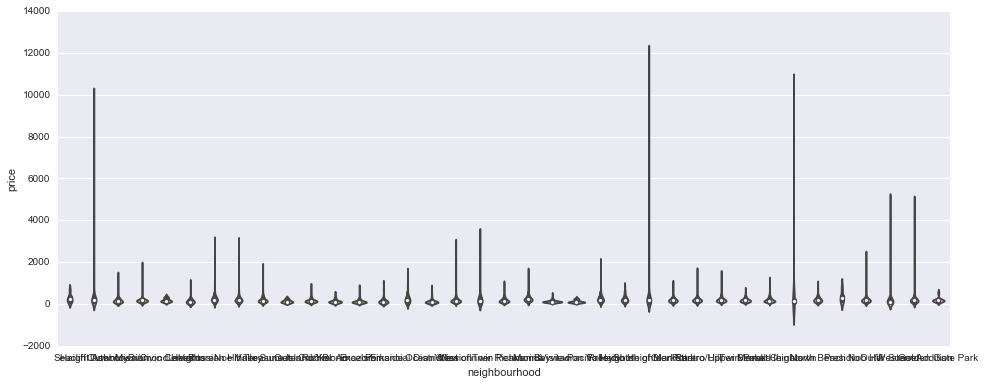

In [15]:
# just a tocuh hard to interpret...
plt.figure(figsize=(16, 6))
sns.violinplot(data=df, x='neighbourhood', y='price')

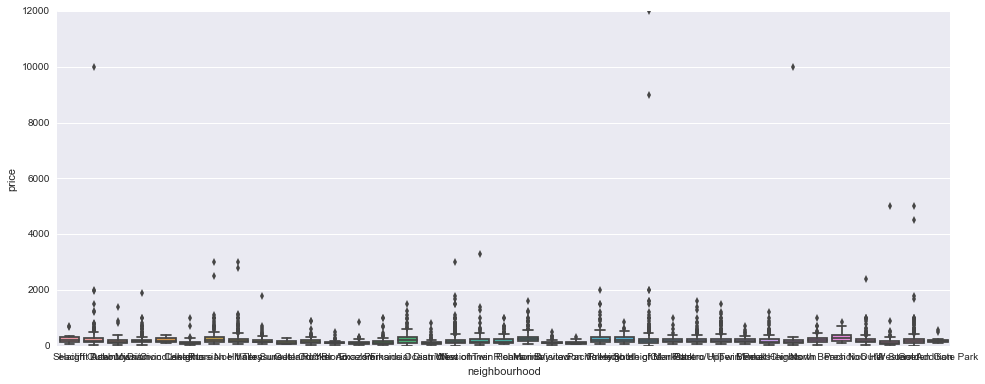

In [16]:
# boxplots can sometimes handle outliers better, we can see here there are some listings that are high priced extrema
plt.figure(figsize=(16, 6))
sns.boxplot(data=df, x='neighbourhood', y='price')

Lets try to only show the 10 neighborhoods with the most listings and to zoom in on the distribution of the lower prices (now that we can identify the outliers) we can remove listings priced at > $2000

In [17]:
top_neighborhoods = df.groupby('neighbourhood').count().sort_values('id', ascending = False).index[:10]
top_neighborhoods

Index([u'Mission', u'Western Addition', u'South of Market',
       u'Castro/Upper Market', u'Haight Ashbury', u'Bernal Heights', u'Marina',
       u'Noe Valley', u'Downtown/Civic Center', u'Nob Hill'],
      dtype='object', name=u'neighbourhood')

In [18]:
neighborhood_subset = df[df.neighbourhood.isin(top_neighborhoods)]

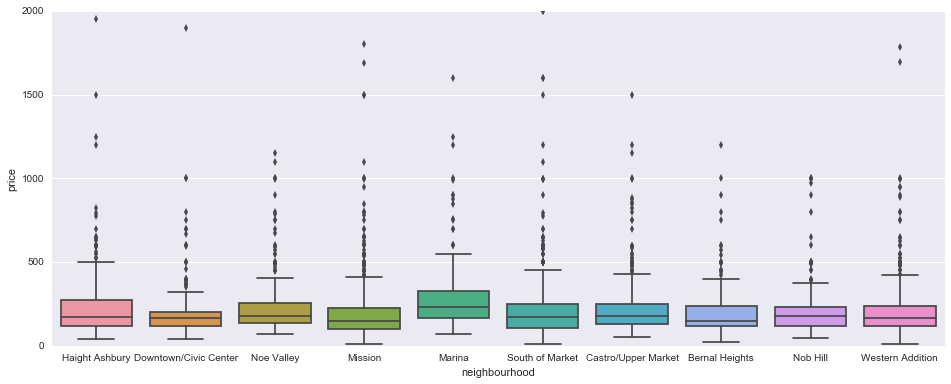

In [19]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=neighborhood_subset[neighborhood_subset.price < 2000], x='neighbourhood', y='price')

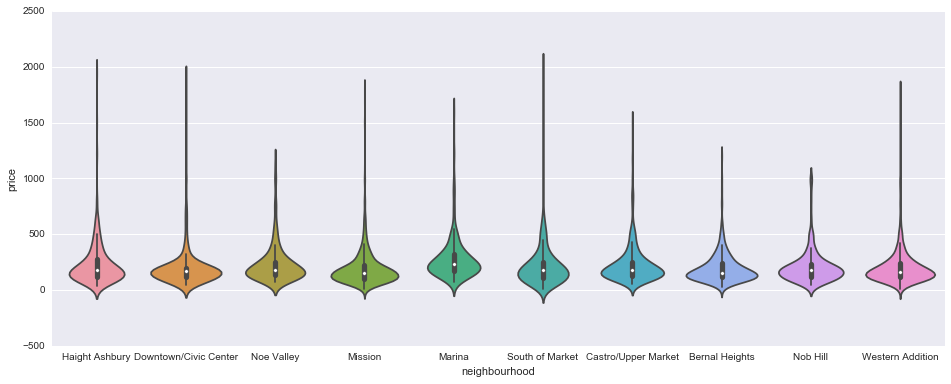

In [20]:
plt.figure(figsize=(16, 6))
sns.violinplot(data=neighborhood_subset[neighborhood_subset.price < 2000], x='neighbourhood', y='price')

### Boxplots vs. Violinplots

* Boxplot
  * Can be easier to interpret (a visual representation of point statistics, the quartiles)
  * Shows individual outlier data points (violinplot only shows range of outliers, max values) 
  * More common and familiar
  * Can be easier to compare a large number of boxplots
  * Can be easier to compare the spread (upper - lower quartile) of the values
* Violinplot
  * Shows more information (distribution rather than point statistic)
  * Will show bimodality (or more complex distribution of values, boxplot collapses this to one number)
  * Shows density of values